In [1]:
%pip install -q python-dotenv langchain-openai langgraph langchain_chroma
%pip install -qU pypdf langchain-community langchain-text-splitters ython-dotenv
%pip install -q "unstructured[md]" nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ython-dotenv (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for ython-dotenv


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
from dotenv import load_dotenv
load_dotenv('../.env')

python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement starting at line 15
python-dotenv could not parse statement starting at line 16
python-dotenv could not parse statement starting at line 18
python-dotenv could not parse statement starting at line 19
python-dotenv could not parse statement starting at line 20


True

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    query: str
    context: str
    answer: str


In [5]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}
    # return {'context': results, 'retry_count': retry_count + 1}

C:\Users\bitcamp\AppData\Local\Temp\ipykernel_14732\3923554161.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [29]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# 허브에서 RAG 프롬프트를 가져옵니다
# generate_prompt = hub.pull("rlm/rag-prompt")

# rag_prompt = """([
#     ('system', '다음 컨텍스트를 바탕으로 사용자의 질문에 답하세요.\n\n{context}'),
#     ('human', '{question}')
# ])"""

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", "다음의 컨텍스트를 바탕으로 사용자의 질문에 답하세요. 컨텍스트에 없는 사실을 답변하지 말고, '모른다고 답하세요'. \n\n{context}"),
    ("human", "{question}")
])

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model='gpt-4o')

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 질문과 답변을 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    # state에서 컨텍스트와 쿼리를 추출합니다
    context = state['context']
    query = state['query']
    
    # 작업 체인을 생성합니다: 먼저 프롬프트를 검색하고, 그 다음 응답을 생성합니다
    rag_chain = rag_prompt | generate_llm | StrOutputParser()
    
    # 쿼리와 컨텍스트로 체인을 호출하여 응답을 얻습니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 반환합니다
    return {'answer': response}

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# OpenAI의 GPT-4o-mini 모델을 사용합니다
basic_llm = ChatOpenAI(model="gpt-4o")  # 간단한 모델

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    # state에서 질문을 추출합니다
    query = state['query']
    
    # 기본 LLM 체인을 생성합니다
    basic_llm_chain = basic_llm | StrOutputParser()
    
    # 체인을 사용하여 답변을 생성합니다
    llm_response = basic_llm_chain.invoke(query)
    
    # 생성된 답변을 'answer'로 반환합니다
    return {'answer': llm_response}

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
from langchain_openai import ChatOpenAI

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(description="The target for the query to answer")

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("human", "{query}")
])

router_llm = ChatOpenAI(model='gpt-4o')
structured_router_llm = router_llm.with_structured_output(Route)

def router(state:AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    """
    사용자의 질문에 기반하여 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        Literal['vector_store', 'llm', 'web_search']: 질문을 처리하기 위한 적절한 경로를 나타내는 문자열.
    """

    query = state['query']
    router_chain = router_prompt | structured_router_llm
    response = router_chain.invoke({'query': query})

    return response.target


In [19]:
graph_builder = StateGraph(AgentState)

In [20]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)  # subgraph
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [21]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START, 
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [22]:
graph = graph_builder.compile()

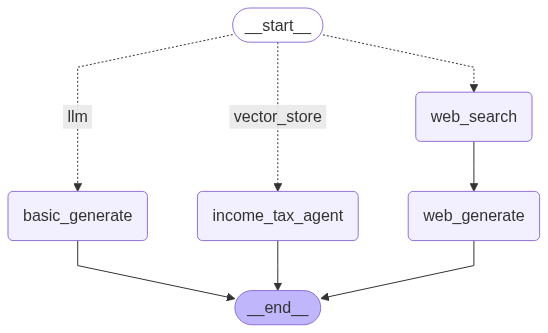

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
initial_state = {'query': '대한민국의 수도는 어디인가요?'}
graph.invoke(initial_state)

{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [25]:
initial_state = {'query': '연소득이 1억원인 사람의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연소득이 1억원인 사람의 소득세는 얼마인가요?',
 'context': [Document(id='88337565-ab92-48d3-925f-e895647a45de', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2

In [30]:
initial_state = {'query': '강남역 일식 맛집을 소개해주세요'}
graph.invoke(initial_state)

{'query': '강남역 일식 맛집을 소개해주세요',
 'context': [{'title': '강남 일식 맛집 강남역 고급 일식집 아카사카 경탄했던 복어회코스',
   'url': 'https://m.blog.naver.com/sensenlebo/222985823575',
   'content': '감탄스러웠던 퀄리티의 강남 일식 맛집 위치는 삼성전자 서초사옥 바로 맞은편으로 지하철 2호선과 신분당선 강남역 6번 출구에서 도보 1~2분이면 도착할 수 있어 대중교통으로 방문하기에도 좋았어요.\n\n\u200b\n\n\u200b\n\n\u200b\n\n\u200b\n\n고급 일식집답게 아늑한 느낌의 룸 위주로 구성되어 있었는데 밖에서 봤을 때보다 안으로 들어가니 분위기가 훨씬 좋았어요.\n\n\u200b\n\n\u200b\n\n\u200b\n\n\u200b\n\n강남역에 위치한 고급 일식집이다보니 비즈니스 손님들이 주를 이룰 것 같았는데 조용하고 프라이빗하게 귀한 분들과 식사하기에 좋아 보였어요.\n\n\u200b\n\n\u200b\n\n\u200b\n\n\u200b\n\n각 룸 공간이 널찍해서 더욱 여유롭고 편안하게 식사할 수 있었던 강남역 일식 맛집 아카사카.\n\n\u200b\n\n\u200b\n\n\u200b\n\n\u200b\n\n이날 저희가 맛본 메뉴는 특별함이 있었던 활복코스요리로 지금부터 하나씩 상세하게 소개해드릴게요. :)\n\n\u200b\n\n\u200b\n\n복어회에 제철 사시미까지\n\n신선하고 좋은 음식이 한가득!\n\n\u200b\n\n\u200b [...] # 블로그\n\n## 카테고리 이동 미니미엄빠\n\n강남 일식 맛집 강남역 고급 일식집 아카사카 경탄했던 복어회코스\n\n프로필\n\n2023. 1. 16. 15:17\n\n강남 일식 맛집\n\n강남역 아카사카\n\n\u200b\n\n귀한 복어회와 랍스터 & 제철 사시미, 다채롭고 신선한 해산물을 가득 맛볼 수 있었던 강남 일식 맛집 다녀왔어요. 그동안 다녀봤던 강남 일대 일식집